In [1]:
%pip install pip tqdm numpy torch torchvision matplotlib scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import random as rd
from tqdm import tqdm

# if torch.backends.mps.is_available():
#     torch.set_default_device("mps")

In [2]:
t = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", download=True, train=True, transform=t)
test_dataset = datasets.MNIST(root="./data", download=True, train=False, transform=t)

In [3]:
len(train_dataset + test_dataset)

70000

In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

In [5]:
for i, (X_train_tensor, y_train_tensor) in enumerate(train_loader):
    print(i, X_train_tensor.shape, y_train_tensor.shape)
    break

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


In [5]:
# Define the MLP architecture
class MNIST_Convo(nn.Module):
    def __init__(self):
        super(MNIST_Convo, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc_lyr1 = nn.Linear(16 * 7 * 7, 128)
        self.fc_lyr2 = nn.Linear(128, 64)
        self.fc_lyr3 = nn.Linear(64, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        out = F.relu(self.conv2(out))
        out = self.pool(out)
        # out = out.reshape(out.size(0), -1)
        out = torch.flatten(out, 1)
        out = F.relu(self.fc_lyr1(out))
        out = F.relu(self.fc_lyr2(out))
        out = self.fc_lyr3(out)

        return out

In [6]:
# Create an instance of the MLP model
model = MNIST_Convo()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)

In [7]:
loss_ar = []

In [8]:
# Train the model
model.train()
epoch = 1

for epoch in (pbar:= tqdm(range(epoch))):
    for i, (X_train_tensor, y_train_tensor) in enumerate(train_loader):
        # Forward pass: Get predictions
        y_pred = model(X_train_tensor)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_train_tensor)
        # print(loss)
        # print((y_pred.squeeze(), y_train_tensor))
        loss_ar.append(loss.item())

        pbar.set_postfix_str(f"Loss: {loss.item()}")
        
        # Zero grad
        optimizer.zero_grad()

        # Backward pass
        loss.backward()
        optimizer.step()
        # break

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:16<00:00, 16.02s/it, Loss: 0.2501112222671509]


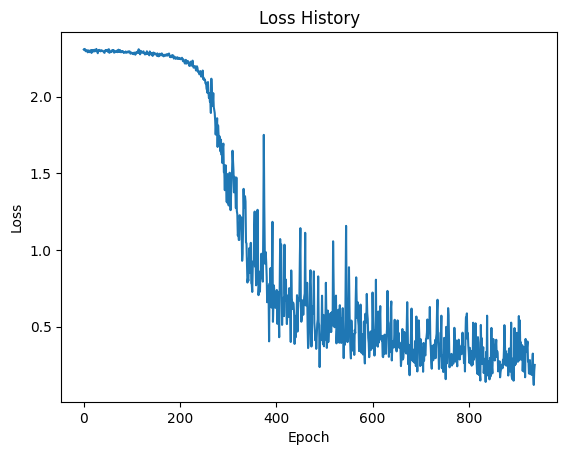

In [9]:
# Plotting the loss history
plt.plot(loss_ar)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Run a test using predefined values

3


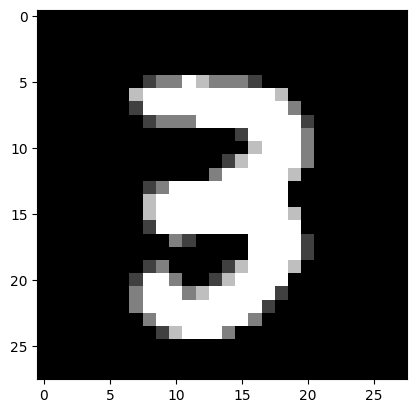

In [10]:
X_input_indx = rd.randint(0, len(test_dataset))

image, label = test_dataset[X_input_indx]
print(label)
plt.imshow(image.squeeze(), cmap='grey')

In [11]:
X_final = torch.from_numpy(np.array([image]))

model.eval()
output = (model(X_final) ** 2).sqrt().squeeze()

o = {}
for i in range(10):
    o[i] = (output / output.sum())[i].item() * 100

sorted(o.items(), key=lambda x: x[1], reverse=True)

[(3, 21.686987578868866),
 (2, 16.650788486003876),
 (6, 15.858341753482819),
 (8, 12.63023316860199),
 (4, 10.340997576713562),
 (1, 7.428058236837387),
 (7, 5.156038329005241),
 (0, 5.1229942589998245),
 (9, 2.8715040534734726),
 (5, 2.254057675600052)]

In [12]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

check_accuracy(loader=train_loader, model=model)
check_accuracy(loader=test_loader, model=model)

Got 54391 / 60000 with accuracy 90.65
Got 9104 / 10000 with accuracy 91.04
